# Load Documents

In [1]:
from pipeline.doc_load.document_loader import multi_xscience_get_text

train, test, val = multi_xscience_get_text()

# Create Topic Model and process sentences

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal number of topics 4


/home/joramas/miniconda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans

> <generator object LLM.generate at 0x7ff189ac4ac0>
> <generator object LLM.generate at 0x7ff189ac4c10>
> <generator object LLM.generate at 0x7ff189ac4580>
> <generator object LLM.generate at 0x7ff167fd7370>


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

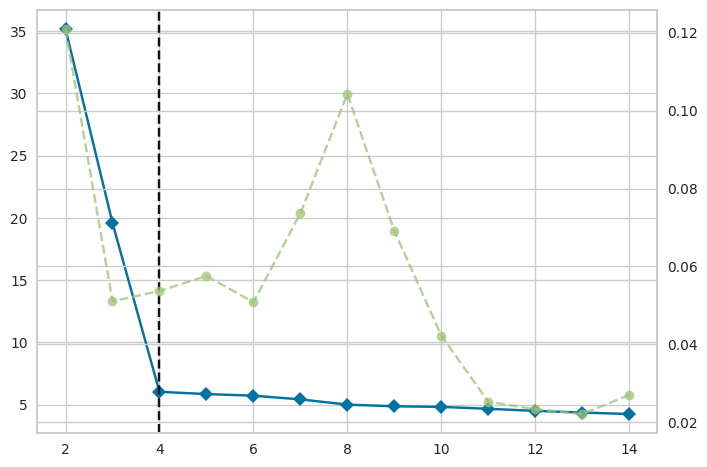

In [ ]:
from pipeline.topic_model.k_means_llm import TopicModel
from pipeline.embeddings.basic_embeddings import Embedding
import pandas as pd

tm = TopicModel()

embed_model = Embedding()
embeddings = embed_model.encode_many(sentences)
embeddings_df = pd.DataFrame(embeddings)


# Get Topics

In [ ]:
topics = tm.get_topics(sentences, embeddings_df)

In [ ]:
print(topics)

# Store Data in Database

In [ ]:
from pipeline.database.chroma_db import ChromaHandler
import uuid
db = ChromaHandler()
colection = db.create_collection(name="test_pipeline")

db.add_embeddings(colection, embeddings=embeddings.tolist(), documents=sentences, metadata=None)

ValueError: Expected IDs to be a list, got None

# Detect Relevant information for the topics

In [ ]:
centroids =  tm.clusters_centroids.tolist()

top_docs = []
for c in centroids:
    top_docs.append(db.query_embeddings(collection=colection, query_embeddings=c, top_k=5)["documents"])

top_docs[0]

[['This is a sentence about technology AI, math, universities 13',
  'This is a sentence about technology AI, math, universities 10',
  'This is a sentence about technology AI, math, universities 14',
  'This is a sentence about technology AI, math, universities 18',
  'This is a sentence about technology AI, math, universities 19']]

In [ ]:
from ctransformers import AutoModelForCausalLM

# Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
llm = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.1-GGUF", 
    model_file="/run/media/joramas/DATA/THESIS/playground/models/mistral-7b-instruct-v0.1.Q5_K_M.gguf", 
    model_type="mistral", 
    gpu_layers=30)

In [ ]:
from gpt4all import GPT4All
model = GPT4All("orca-mini-3b-gguf2-q4_0.gguf")
output = model.generate("The capital of France is ", max_tokens=50)
print(output)